In [7]:
import preprocessing

from matplotlib import pyplot as plt

Found 209 files.
(209, 128, 128, 3)


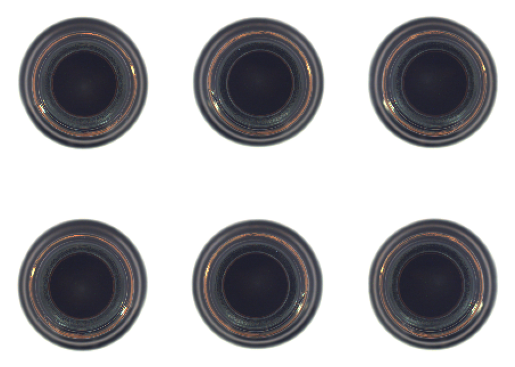

In [8]:
image_dir = "../dataset/AUTO_Input/train/"
image_size = (128, 128)
images = preprocessing.import_images(image_dir, image_size)
images = preprocessing.normalize_images(images)
print(images.shape)
rot_images = preprocessing.rotate_all_90(images)
mirrored_x_images = preprocessing.mirror_images(images, 0)
mirrored_y_images = preprocessing.mirror_images(images, 1)

for i, (image1, image2) in enumerate(zip(images[0:3], mirrored_y_images[0:3])):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image1)
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 3, i + 1 + 3)
    plt.imshow(image2)
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

#test = preprocessing.mirror_images(images, 3)